In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from sympy.logic import SOPform, boolalg
from sympy import symbols, srepr, Not
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from BoolFuncModule.BoolFunc import BoolFunc
import BoolFuncModule.ParameterAssignment as PA
import BoolFuncModule.NNfunctions as NNf
import BoolFuncModule.RobustnessFunctions as RF

In [3]:
testFunc = BoolFunc(parameterType=3)

print(testFunc.get_parameters())
print(testFunc.get_SOP())
print(testFunc.get_D())
print(testFunc.forward(np.array([[1], [1], [1]])))
print(testFunc.get_truth_table())
print(testFunc.get_robustness())

(array([[ 1,  1,  0],
       [ 0,  1, -1],
       [ 0,  0,  0],
       [ 0, -1,  0]]), array([[-1],
       [ 0],
       [ 0],
       [ 1]]), array([[ 0, -1,  0,  0]]), 1)
2 | ~1
3
[[1]]
11011101
0.6785714285714286


In [4]:
W1, b1, W2, b2 = testFunc.get_parameters()
RF.mutate_W2(W2, b2, 0)

array([[-1, -1,  0,  0]])

In [5]:
sampleSize = 5000
parameterType = 3

frequencyDict = {}
for i in tqdm(range(sampleSize)):
    function = BoolFunc(n=3, parameterType=parameterType)
    isInDict = False
    SOP = function.get_SOP()
    if SOP is True or SOP is False or not isinstance(SOP, boolalg.Or):      # accounts for SOPs with just one literal for which equals() function seems to fail.
        for key in frequencyDict:
            if function.get_SOP() == key:
                frequencyDict[key][0] += 1
                frequencyDict[key][2] = ((frequencyDict[key][0]-1)*frequencyDict[key][2] + function.get_robustness())/frequencyDict[key][0]
                isInDict = True
                break
    else:
        for key in frequencyDict:
            if function.get_SOP().equals(key):
                frequencyDict[key][0] += 1
                isInDict = True
                break
    if isInDict is False:
        frequencyDict[SOP] = [1, function.get_D(), function.get_robustness()]
        



100%|██████████| 5000/5000 [25:53<00:00,  3.22it/s]  


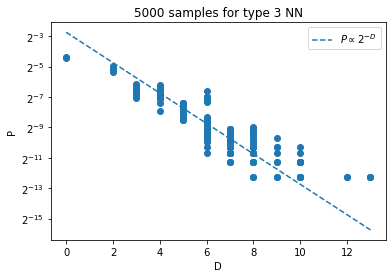

In [6]:
P = [val[0]/sampleSize for key, val in frequencyDict.items()]
D = [val[1] for key, val in frequencyDict.items()]
R = [val[2] for key, val in frequencyDict.items()]

x = np.linspace(0, max(D), 100)
y = 0.15*2**(-x)

plt.scatter(D, P)
plt.plot(x,y, linestyle='--', label='$P\propto2^{-D}$')
plt.yscale('log', base=2)
plt.title(f'{sampleSize} samples for type {parameterType} NN')
plt.xlabel('D')
plt.ylabel('P')
plt.legend()
plt.savefig(f'type{parameterType}/P_vs_D_samples{sampleSize}.png')
plt.show()

In [8]:
k = 3
l = 16

logF_cont = pd.read_csv('k'+str(k)+'_l'+str(l)+'/logF_continuous.txt', header=None)
rho_blancmange = pd.read_csv('k'+str(k)+'_l'+str(l)+'/rho_blancmange.txt', header=None)
rho_1comp_min = pd.read_csv('k'+str(k)+'_l'+str(l)+'/rho_1comp_min.txt', header=None)
rho_lower = pd.read_csv('k'+str(k)+'_l'+str(l)+'/rho_lower.txt', header=None)
rho_upper = pd.read_csv('k'+str(k)+'_l'+str(l)+'/rho_upper.txt', header=None)
rho_null = pd.read_csv('k'+str(k)+'_l'+str(l)+'/rho_null.txt', header=None)

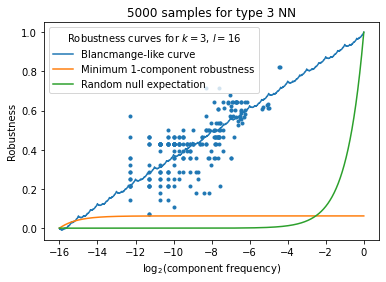

In [9]:
plt.scatter(np.log2(P), R, marker='.')
plt.plot(logF_cont, rho_blancmange, label='Blancmange-like curve')
plt.plot(logF_cont, rho_1comp_min, label='Minimum 1-component robustness')
plt.plot(logF_cont, rho_null, label='Random null expectation')
plt.title(f'{sampleSize} samples for type {parameterType} NN')
plt.xlabel('log$_2$(component frequency)')
plt.ylabel('Robustness')
plt.legend(title='Robustness curves for $k=3$, $l=16$')
plt.savefig(f'type{parameterType}/R_vs_logP_samples{sampleSize}.png')
plt.show()
